In [4]:
import sys
import numpy as np
# import scikitlearn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import glob

# ML Magic:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error
)

from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    MinMaxScaler
)

# Local includes:
sys.path.append("../../src/")
import therm_params as tp
from power_model import (
    leakagePower,
    peripheral_power,
    board_power
)


# Setting to make pandas show floats in non-scientific notation:
pd.options.display.float_format = '{:.3f}'.format

In [5]:
# blackscholes_files = glob.glob("../blackscholes_benchmarking/*.csv")
blackscholes_files = ["../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"]
bodytrack_files = glob.glob("../bodytrack_benchmarking/*.csv")
# random_data = ["../bodytrack_benchmarking/random_mc1_4_log_4_1_2018.csv"]
# random_data = ["../bodytrack_benchmarking/xu4_random_loads_4_1_2018.csv"]
# random_data = ["big_cores_random_freq_load_BODYTRACK.csv"]
random_data = ["../../xu3_src/xu3_random_log_jan_20.log"]
files = random_data

In [8]:
df_list = []

def leak_row_big(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_big_cluster, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)
    
def leak_row_little(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_little_cluster, \
            np.mean( [row.temp4, row.temp5, row.temp6, row.temp7, row.temp_gpu] ) + 273.15)

def leak_row_gpu(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_gpu, row.temp_gpu + 273.15 )

def leak_row_mem(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_mem, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)

def process_dataframe_list(df_list):
    data = pd.concat(df_list, ignore_index=True)
    # Drop all measurements where watts <= 0:
    data = data.loc[data.watts > 0]
    # fill in the potentially missing voltage values
    data["volts_big_cluster"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000])
    data["volts_little_cluster"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000])
    # Replace with correct value for gpu and mem voltage:
    data["volts_gpu"] = 1.0
    data["volts_mem"] = 1.2
    # Recompute the leakage power:
    data['leak_big'] = data.apply(leak_row_big, axis=1)
    data['leak_little'] = data.apply(leak_row_little, axis=1)
    data['leak_gpu'] = data.apply(leak_row_gpu, axis=1)
    data['leak_mem'] = data.apply(leak_row_mem, axis=1)
    data['w_leak2'] = data.apply(lambda row: np.sum( [row.leak_big, row.leak_little, row.leak_gpu, row.leak_mem] ), axis=1)

    data_filtered = data.copy()
    data_filtered["usage_little"] = data[["usage_c0", "usage_c1", "usage_c2", "usage_c3"]].apply(func = np.sum, axis=1)
    data_filtered["usage_big"] = data[["usage_c4", "usage_c5", "usage_c6", "usage_c7"]].apply(func = np.sum, axis=1)
    data_filtered["max_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.max, axis=1)
    data_filtered["avg_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.mean, axis=1)
    data_filtered["vvf_b"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000]**2 * (x/1000000000))
    data_filtered["vvf_l"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000]**2 * (x/1000000000))
    data_filtered["p_dyn"] = data.apply(lambda row: row.watts - row.w_leak2 - peripheral_power, axis=1)
    data_filtered["p_big_dyn"] = data.apply(lambda row: row.w_big - row.leak_big, axis=1)
    data_filtered["aVVFb"] = data_filtered.apply(lambda row: row.usage_big * row.vvf_b, axis=1)
    data_filtered["aVVFl"] = data_filtered.apply(lambda row: row.usage_little * row.vvf_l, axis=1)
    data_filtered["gpu_mem"] = 1
    data_filtered['p_total'] = data.watts
    data_filtered['p_leak'] = data.w_leak2
    # Sanity check:
    min_p_dyn = np.min(data_filtered.p_dyn.loc[data_filtered['p_dyn'] < 0])
    if not pd.isnull(min_p_dyn):
        data_filtered -= min_p_dyn
    return data_filtered

In [9]:
for file in files:
    df = pd.read_csv(file, index_col=False, header=0, sep='\t')
    df_list.append(df)
    
data_filtered = process_dataframe_list(df_list)
data_filtered.describe()

,time,watts,w_big,w_little,w_gpu,w_mem,usage_c0,usage_c1,usage_c2,usage_c3,...,avg_temp_big,vvf_b,vvf_l,p_dyn,p_big_dyn,aVVFb,aVVFl,gpu_mem,p_total,p_leak
count,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,...,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000,237951.000
mean,1516514396.663,4.145,1.258,0.180,0.206,0.121,0.278,0.150,0.105,0.102,...,66.698,0.814,1.008,1.399,1.135,1.211,0.306,1.077,4.145,0.569
std,13753.542,1.279,0.953,0.059,0.016,0.008,0.132,0.076,0.067,0.063,...,8.267,0.429,0.633,1.161,0.919,1.012,0.180,0.000,1.279,0.131
min,1516490574.847,2.596,0.174,0.109,0.172,0.109,0.077,0.077,0.077,0.077,...,49.077,0.239,0.239,0.000,0.089,0.077,0.077,1.077,2.596,0.356
25%,1516502485.987,3.211,0.531,0.130,0.195,0.115,0.168,0.077,0.077,0.077,...,60.827,0.482,0.482,0.548,0.433,0.482,0.193,1.077,3.211,0.477
50%,1516514396.587,3.737,0.931,0.156,0.202,0.118,0.244,0.144,0.077,0.077,...,64.827,0.725,0.877,1.033,0.820,0.976,0.253,1.077,3.737,0.531
75%,1516526307.557,4.665,1.702,0.222,0.213,0.127,0.344,0.154,0.077,0.077,...,70.827,1.123,1.438,1.881,1.573,1.619,0.363,1.077,4.665,0.617
max,1516538218.347,13.333,7.362,0.457,0.267,0.186,1.005,1.010,0.959,1.010,...,94.077,1.620,2.264,10.314,7.178,6.251,2.994,1.077,13.333,1.060


In [10]:
data_filtered.head()

,time,watts,w_big,w_little,w_gpu,w_mem,usage_c0,usage_c1,usage_c2,usage_c3,...,avg_temp_big,vvf_b,vvf_l,p_dyn,p_big_dyn,aVVFb,aVVFl,gpu_mem,p_total,p_leak
0,1516490574.847,2.985,0.467,0.119,0.175,0.110,0.327,0.148,0.144,0.144,...,51.827,0.401,0.401,0.437,0.397,0.077,0.224,1.077,2.985,0.371
1,1516490575.047,2.932,0.458,0.121,0.175,0.114,0.308,0.148,0.077,0.144,...,51.577,0.401,0.401,0.390,0.390,0.077,0.196,1.077,2.932,0.365
2,1516490575.247,3.008,0.458,0.121,0.175,0.114,0.363,0.148,0.077,0.077,...,51.577,0.401,0.401,0.466,0.390,0.077,0.193,1.077,3.008,0.365
3,1516490575.447,2.985,0.457,0.125,0.175,0.112,0.350,0.148,0.077,0.077,...,51.577,0.401,0.401,0.443,0.389,0.077,0.188,1.077,2.985,0.365
4,1516490575.647,2.985,0.459,0.121,0.175,0.115,0.308,0.210,0.139,0.077,...,51.577,0.401,0.401,0.443,0.391,0.077,0.215,1.077,2.985,0.365


In [12]:
model_cols = ["usage_little", "usage_big", "max_temp_big", "avg_temp_big", "vvf_b", "vvf_l", "p_total"]
X = data_filtered.loc[:, model_cols]
# y = data_filtered.p_total
# Or:
# y = data_filtered.p_dyn
# Or:
y = data_filtered.w_big

# Fit and apply a scaler to the data:
# scaler = MinMaxSaler()
# scaler.fit(X)
# X = scaler.transform(X)

activator = 'relu'
alpha_r = .1
hidden_layer_sizes = (100, 60, 10)
maximum_iterations = 200
# The model:
TPM = MLPRegressor(activation=activator, alpha=alpha_r,\
                   hidden_layer_sizes=hidden_layer_sizes,\
                  random_state = 45, max_iter=maximum_iterations)
# # Create training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)#, shuffle=True) 
# Train the model:
TPM = TPM.fit(X_train, y_train)
P = TPM.predict(X_test)

In [13]:
R = TPM.score(X_test, y_test)
R

0.96297651442523435

In [14]:
mean_squared_error( list(y_test.values), list(P) )

0.033834407081939508

In [15]:
pd.DataFrame([list(P), list(y_test.values)] )

,0,1,2,3,4,5,6,7,8,9,...,95171,95172,95173,95174,95175,95176,95177,95178,95179,95180
0,2.274,1.290,0.460,2.433,1.127,2.236,0.914,3.194,3.517,0.635,...,0.361,0.759,0.838,2.349,0.740,1.111,0.619,0.610,0.959,3.090
1,2.417,1.151,0.510,1.743,1.122,2.497,0.915,3.199,3.603,0.613,...,0.363,0.793,0.918,2.327,0.683,1.125,0.601,0.489,0.898,3.082


In [17]:
# Load some other data and test/plot it:
f_test = "../../xu3_src/test_random_logging.log"

to_plot = pd.read_csv(f_test, index_col=False, header=0, sep='\t')
other_XY = process_dataframe_list([to_plot])

In [19]:
X_plot = other_XY.loc[:, model_cols]
# X_plot = scaler.transform(X_plot)
y_plot = other_XY.p_dyn
# y_plot = other_XY.p_total

In [22]:
P_plot = TPM.predict(X_plot)
TPM.score(X_plot, y_plot)

0.60921166525542081

In [23]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.0086369150657793544

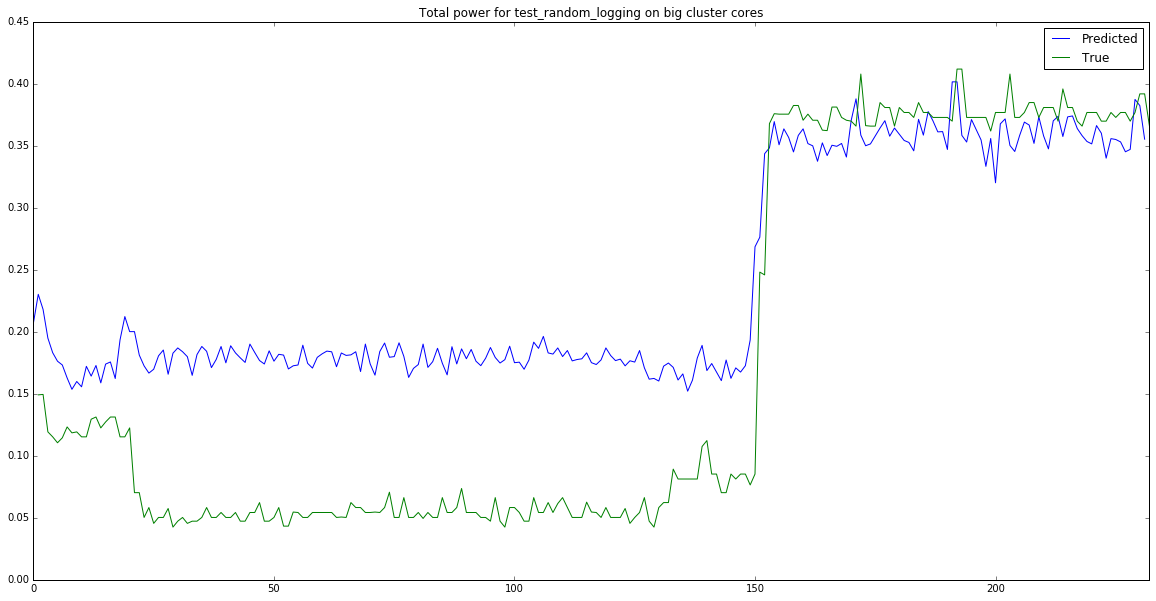

In [24]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted")
y_plot.plot(label="True")
plt.legend()
plt.title("Total power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
plt.show()

In [173]:
X_hack = np.identity(X.shape[1])
model_coeffs = DPM.predict(X_hack)
print("Model coefficients:")
print(model_coeffs)

#using from above:
# def leak_row_big(row):
# def leak_row_little(row):
# Defining now:
def dyn_row_big(row):
    global model_coeffs, model_cols
    total = 0
    for index, label in enumerate(model_cols):
        if label == "aVVFb" or label == "vvf_b":
            total += row[label] * model_coeffs[index]
    return total

def dyn_row_little(row):
    global model_coeffs, model_cols
    total = 0
    for index, label in enumerate(model_cols):
        if label == "aVVFl" or label == "vvf_l":
            total += row[label] * model_coeffs[index]
    return total

Model coefficients:
[ 5.02612639  0.13151792  2.06747626]


In [174]:
foo = pd.DataFrame(data=X_plot, columns = model_cols)

In [175]:
dyn_power_est = other_XY.loc[:,['time', 'temp4', 'temp5', 'temp6', 'temp7']].copy()
# Estimate the dynamic power for the big cluster:
dyn_power_est['big_dyn'] = foo.apply(dyn_row_big, axis=1)
    
# Total power for big cluster is dynamic plus leakage:
dyn_power_est['big_tot'] = other_XY['leak_big'] + dyn_power_est['big_dyn']

In [176]:
# Estimate the dynamic power for the LITTLE cluster:
dyn_power_est['little_dyn'] = foo.apply(dyn_row_little, axis=1)

# Total power for LITTLE cluster is dynamic plus leakage:
dyn_power_est['little_tot'] = other_XY['leak_little'] + dyn_power_est['little_dyn']

In [177]:
dyn_power_est['little_dyn'].describe()

count   1569.000
mean       0.003
std        0.007
min       -0.000
25%        0.001
50%        0.002
75%        0.003
max        0.159
Name: little_dyn, dtype: float64

In [178]:
dyn_power_est['big_dyn'].describe()

count   1569.000
mean       1.299
std        1.403
min       -0.000
25%        0.023
50%        0.124
75%        2.833
max        5.064
Name: big_dyn, dtype: float64

In [179]:
# Generate a set of unique colors so that two separate axes won't share any colors
def genColor(num_curves=10):
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=num_curves-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    idx = 0
    while idx < num_curves:
        colorVal = scalarMap.to_rgba(idx)
#     colorText = (
#         'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
#         )
        idx += 1
        yield colorVal

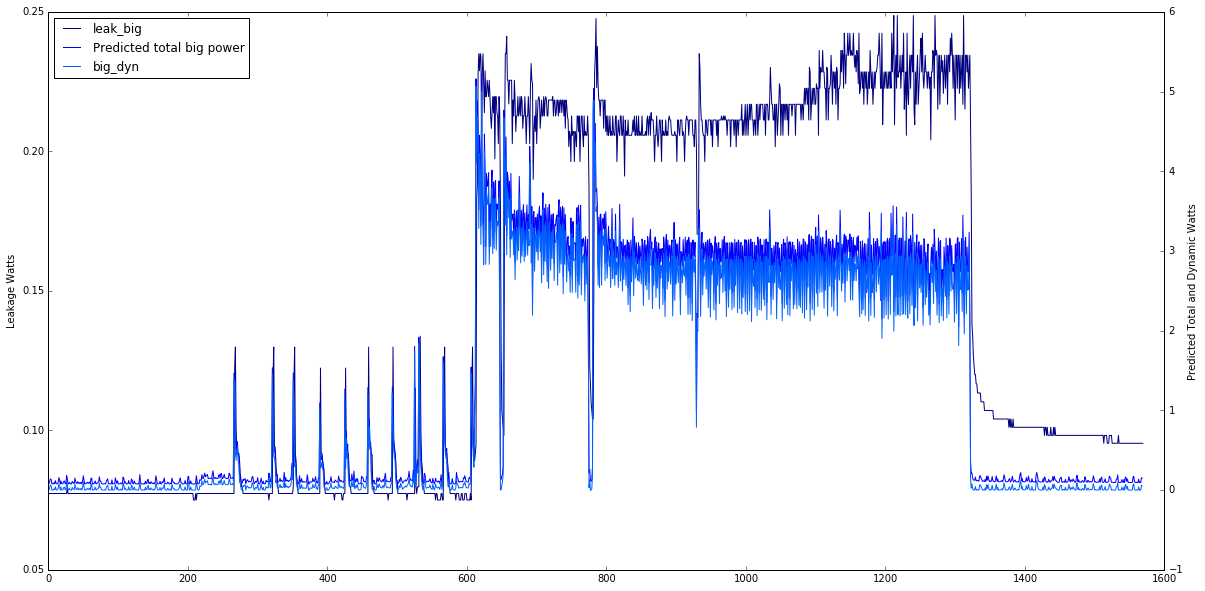

In [180]:
# Plot data for both big and little clusters
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.rcParams["figure.figsize"] = [20,10]

color_gen = genColor(10)

# little cluster leakage
# lns1 = ax1.plot(range(len(other_XY.leak_little)), other_XY.leak_little, color=next(color_gen), label="leak_little")
# big cluster leakage
lns2 = ax1.plot(range(len(other_XY.leak_big)), other_XY.leak_big, color=next(color_gen), label="leak_big")
ax1.set_ylabel("Leakage Watts")
ax2 = ax1.twinx()
# Little cluster
# lns3 = ax2.plot(range(len(dyn_power_est.little_tot)), dyn_power_est.little_tot, color=next(color_gen), label="Predicted total LITTLE power")
# lns4 = ax2.plot(range(len(dyn_power_est.little_dyn)), dyn_power_est.little_dyn, color=next(color_gen), label="little_dyn")
# big cluster
lns5 = ax2.plot(range(len(dyn_power_est.big_tot)), dyn_power_est.big_tot, color=next(color_gen), label="Predicted total big power")
lns6 = ax2.plot(range(len(dyn_power_est.big_dyn)), dyn_power_est.big_dyn, color=next(color_gen), label="big_dyn")
ax2.set_ylabel("Predicted Total and Dynamic Watts")

# lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
lns = lns2 + lns5 + lns6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

In [23]:
other_XY['scaled_usage_0'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c0/row.usage_little, axis=1)
other_XY['scaled_usage_1'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c1/row.usage_little, axis=1)
other_XY['scaled_usage_2'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c2/row.usage_little, axis=1)
other_XY['scaled_usage_3'] = other_XY.apply(lambda row: 0.25 if \
                    row.usage_little == 0 else row.usage_c3/row.usage_little, axis=1)

In [181]:
other_XY['scaled_usage_4'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c4/row.usage_big, axis=1)
other_XY['scaled_usage_5'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c5/row.usage_big, axis=1)
other_XY['scaled_usage_6'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c6/row.usage_big, axis=1)
other_XY['scaled_usage_7'] = other_XY.apply(lambda row: 0.25 if \
                        row.usage_big < 0.02 else row.usage_c7/row.usage_big, axis=1)

In [25]:
dyn_power_est['0_tot'] = other_XY.scaled_usage_0 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['1_tot'] = other_XY.scaled_usage_1 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['2_tot'] = other_XY.scaled_usage_2 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little
dyn_power_est['3_tot'] = other_XY.scaled_usage_3 * dyn_power_est.little_dyn + 0.25 * other_XY.leak_little`

In [182]:
dyn_power_est['4_tot'] = other_XY.scaled_usage_4 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['5_tot'] = other_XY.scaled_usage_5 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['6_tot'] = other_XY.scaled_usage_6 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big
dyn_power_est['7_tot'] = other_XY.scaled_usage_7 * dyn_power_est.big_dyn + 0.25 * other_XY.leak_big

In [183]:
dyn_power_est.to_csv("matlab_temp_sys_identification_verification_blackscholes_big_only.csv", sep=',', index=False)

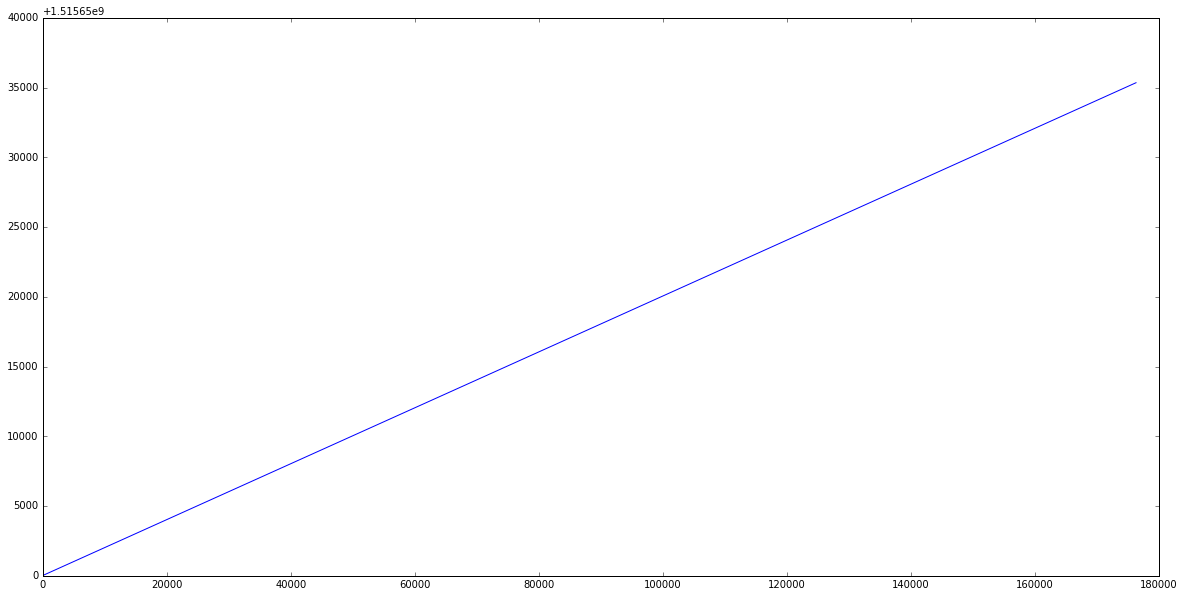

In [184]:
# Make sure the training data is continuous:
plt.plot(data_filtered.index, data_filtered.time)
plt.show()
data_filtered_slice = data_filtered.loc[:, :].copy()

In [23]:
# Now to use the estimates for cluster dynamic + leakage = total power 
# to make predictions on thermals per big core:
# T_next = T_now * A + P_now_est * B
# T_now is the vector of temperatures measured on the system: [T4, T5, T6, T7]
# Note: in other work the GPU temperature could be included and predicted as well.
# P_now_est is the vector of estimated powers used by each big core: [P4, P5, P6, P7]
# Note: it may make more sense to include the power estimate for the little core/clusters as well?
# T_next is the corresponding vector to T_now of temperatures, except that the values are predicted.

In [52]:
# First need to output data with which to do system identification
# From the entire random input (30% of which was used for training),
# generate the estimated power for the big and little clusters:
data_transformed = scaler.transform(data_filtered_slice.loc[:,model_cols])
foo2 = pd.DataFrame(data=data_transformed, columns = model_cols)
sys_identification_data = data_filtered_slice.loc[:,['time', 'temp4', 'temp5', 'temp6', 'temp7']].copy()
sys_identification_data['big_dyn'] = foo2.apply(dyn_row_big, axis=1)
# sys_identification_data['little_dyn'] = foo2.apply(dyn_row_little, axis=1)

In [32]:
data_filtered_slice['scaled_usage_0'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c0/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_1'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c1/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_2'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c2/row.usage_little, axis=1)
data_filtered_slice['scaled_usage_3'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_little == 0 else row.usage_c3/row.usage_little, axis=1)

In [185]:
data_filtered_slice['scaled_usage_4'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c4/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_5'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c5/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_6'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c6/row.usage_big, axis=1)
data_filtered_slice['scaled_usage_7'] = data_filtered_slice.apply(lambda row: 0.25 if \
                                    row.usage_big < 0.02 else row.usage_c7/row.usage_big, axis=1)

In [34]:
sys_identification_data['0_tot'] = data_filtered_slice.scaled_usage_0 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['1_tot'] = data_filtered_slice.scaled_usage_1 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['2_tot'] = data_filtered_slice.scaled_usage_2 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little
sys_identification_data['3_tot'] = data_filtered_slice.scaled_usage_3 * sys_identification_data.little_dyn + 0.25 * data_filtered_slice.leak_little

In [186]:
sys_identification_data['4_tot'] = data_filtered_slice.scaled_usage_4 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['5_tot'] = data_filtered_slice.scaled_usage_5 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['6_tot'] = data_filtered_slice.scaled_usage_6 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big
sys_identification_data['7_tot'] = data_filtered_slice.scaled_usage_7 * sys_identification_data.big_dyn + 0.25 * data_filtered_slice.leak_big

In [187]:
sys_identification_data2 = sys_identification_data.copy(deep=True)
sys_identification_data2.dropna(axis=0, how='any', inplace=True)
sys_identification_data2.describe()

,time,temp4,temp5,temp6,temp7,big_dyn,4_tot,5_tot,6_tot,7_tot
count,176340.000,176340.000,176340.000,176340.000,176340.000,176340.000,176340.000,176340.000,176340.000,176340.000
mean,1515667682.652,66.094,70.514,69.860,66.281,2.797,1.092,0.941,0.851,0.864
std,10198.018,5.915,6.658,6.659,5.413,2.073,1.271,1.045,1.093,1.145
min,1515650019.215,48.095,50.095,50.095,49.095,0.000,0.049,0.049,0.047,0.047
25%,1515658850.945,62.095,66.095,65.095,62.095,0.965,0.256,0.230,0.184,0.178
50%,1515667682.755,65.095,69.095,68.095,65.095,2.326,0.550,0.503,0.384,0.368
75%,1515676514.335,69.095,74.095,73.095,69.095,4.350,1.487,1.306,0.992,0.994
max,1515685345.875,87.095,92.095,92.095,85.095,13.953,8.337,8.516,8.331,8.480


In [188]:
sys_identification_data2.to_csv("matlab_temp_sys_identification_big_only.csv", sep=',', index=False)